In [1]:
# Dowloading a file from a URL in python
import urllib.request

# URL of the file you want to download
url = 'https://www.dropbox.com/s/dtw18saps0231yn/BrainTumorData.zip?dl=0'

# Local filename to save the downloaded file
filename = 'BrainTumorData.zip'

# Download the file
urllib.request.urlretrieve(url, filename)

print(f"{filename} downloaded successfully!")

BrainTumorData.zip downloaded successfully!


In [2]:
# import zipfile
# import os

# # zip_file_path = "C:/Users/Desktop/I have no idea what im doing/Study/BrainTumorData.zip"
# zip_file_path = r'C:\Users\User\Desktop\I have no idea what im doing\Study\BrainTumorData.zip'
# extract_dir = r'C:\Users\User\Desktop\I have no idea what im doing\Study\BrainTumorData'

# # Unzipping the file
# with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
#     zip_ref.extractall(extract_dir)

# print(f"Files has been extracted to {extract_dir}")

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os   #help with file directories
import math
import shutil    # moves file from 1 to another
import glob

import tqdm
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D,Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
train_data_path = r"C:\Users\User\Desktop\DataSet\Breast Cancer\train"
test_data_path = r"C:\Users\User\Desktop\DataSet\Breast Cancer\test"
val_data_path = r"C:\Users\User\Desktop\DataSet\Breast Cancer\valid"

In [6]:
# # Count the number of images in respective classes 0- cancer, 1- normal
# ROOT_DIR = r"C:\Users\User\Desktop\DataSet\Breast Cancer"
# number_of_images = {}

# for dir in os.listdir(ROOT_DIR):
#     number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

# number_of_images.items()

In [7]:
# Count the number of images in respective classes 0- cancer, 1- normal
ROOT_DIR = r"C:\Users\User\Desktop\DataSet\Breast Cancer"
number_of_images = {}

# Loop through 'test', 'train', and 'valid' directories
for main_dir in os.listdir(ROOT_DIR):
    class_dir = os.path.join(ROOT_DIR, main_dir)    # e.g., test, train, valid (creating full path DataSet\Breast Cancer\test, so can access files inside)
    number_of_images[main_dir] = {}

    # loop through class folders inside each test, train, valid directories
    for class_folder in os.listdir(class_dir):
        class_path = os.path.join(class_dir, class_folder)
        number_of_images[main_dir][class_folder] = len(os.listdir(class_path))

number_of_images.items()

dict_items([('test', {'0': 208, '1': 128}), ('train', {'0': 1569, '1': 803}), ('valid', {'0': 448, '1': 227})])

In [8]:
# spliting datas into training/test/valid folders

# create a new directory for a dataset, move a specified fraction of images 
# from the original dataset into this new directory

def dataFolder(path, split):
    # checks if specific path existed, create it
    if not os.path.exist("./" + path):
        os.mkdir("./" + path)

        # Looping through 1,0
        for dir in os.listdir(ROOT_DIR):
            # If any part of the path doesn't exist, it creates it (making multiple paths)
            os.makedirs("./" + path + "/" + dir)
            # Randomly select, move imgs
            for img in np.random.choice(a = os.listdir(os.path.join(ROOT_DIR, dir)), 
                                        size = (math.floor(split*number_of_images[dir]) -5),
                                        # Ensure same img not chosen
                                        replace=False):
                O = os.path.join(ROOT_DIR, dir, img)
                D = os.path.join("./" + p, dir)
                # Copy and Remove Images
                shutil.copy(O, D)
                os.remove(O)
    else:
        print(f"{path} Folder existed")

Model Building

In [9]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as keras

In [10]:
# CNN MODEL

model = Sequential()
# kernel_size, size of Convolusion filer (industry stand)

# First layer (Move you zoom in, more you'll see)
model.add(Conv2D(filters= 16, kernel_size = (3,3), activation= "relu", input_shape= (224,224,3)))

model.add(Conv2D(filters= 36, kernel_size = (3,3), activation= "relu" ))
# Prevent overfitting
model.add(MaxPool2D(pool_size= (2,2)))

model.add(Conv2D(filters= 64, kernel_size = (3,3), activation= "relu" ))
model.add(MaxPool2D(pool_size= (2,2)))

model.add(Conv2D(filters= 128, kernel_size = (3,3), activation= "relu" ))
model.add(MaxPool2D(pool_size= (2,2)))

model.add(Dropout(rate= 0.25))

model.add(Flatten())
model.add(Dense(units= 64, activation= "relu"))
model.add(Dropout(rate= 0.25))
model.add(Dense(units= 1, activation= "sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 36)      5220      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 36)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      20800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       7

In [11]:
model.compile(optimizer="adam", loss= keras.losses.binary_crossentropy, metrics=["accuracy"])

Preparting data using Data Generator

In [12]:
def preprocessingImages(path):
    """
    input= path
    output= pre processed images
    """
    # data augmentation
    # Why?, to increase dimension, got a new pen, everything is different, how to differentiate one pen and the other?
    # by making indeepth anal
    image_data = ImageDataGenerator(zoom_range= 0.2, shear_range= 0.2, rescale= 1/255, horizontal_flip= True)
    # target_size same as the size of model 
    image = image_data.flow_from_directory(directory= path, target_size= (224,224), batch_size= 32, class_mode= "binary")

    return image

In [13]:
def preprocessingImagesValidation(path):
    # want it to be as natural as possible
    """
    input= path
    output= pre processed images
    """
    image_data = ImageDataGenerator(rescale= 1/255)
    image = image_data.flow_from_directory(directory= path, target_size= (224,224), batch_size= 32, class_mode= "binary")

    return image

In [14]:
path = r"C:\Users\User\Desktop\DataSet\Breast Cancer\train"

train_data = preprocessingImages(path)

Found 2372 images belonging to 2 classes.


In [15]:
path = r"C:\Users\User\Desktop\DataSet\Breast Cancer\valid"

valid_data = preprocessingImagesValidation(path)

Found 675 images belonging to 2 classes.


In [16]:
path = r"C:\Users\User\Desktop\DataSet\Breast Cancer\test"

test_data = preprocessingImagesValidation(path)

Found 336 images belonging to 2 classes.


Train model

In [17]:
# Early stopping and model check point
# highest acc in that time frame
# sometimes results can come up early, dw model to waste resource by training all other parameters

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Early stopping
es = EarlyStopping(monitor= "val_accuracy", min_delta= 0.01, patience= 6, verbose= 1, mode= "auto")

# Model checkpoint
# filepath, where best model saved
mc = ModelCheckpoint(monitor= "val_accuracy", filepath= "./bestmodel.h5" , verbose=1, save_best_only=True ,mode= "auto")

# passing it as an array in model.fit
cd = [es, mc]

Model Training

In [18]:
# history, how our model working, val data/ val accuracy respect to training/ validation

# reduces effort of manually adding up all of these datas
# verbose, show execution displays
hs = model.fit_generator(generator= train_data, 
                         steps_per_epoch= 8, 
                         epochs= 30, 
                         verbose=1, 
                         validation_data= valid_data, 
                         validation_steps=16, 
                         callbacks= cd)

Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 0.7121 - accuracy: 0.6328
Epoch 1: val_accuracy improved from -inf to 0.65430, saving model to .\bestmodel.h5
8/8 [==============================] - 57s 7s/step - loss: 0.7121 - accuracy: 0.6328 - val_loss: 0.6660 - val_accuracy: 0.6543
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 0.6509 - accuracy: 0.6484
Epoch 2: val_accuracy improved from 0.65430 to 0.67383, saving model to .\bestmodel.h5
8/8 [==============================] - 48s 6s/step - loss: 0.6509 - accuracy: 0.6484 - val_loss: 0.6356 - val_accuracy: 0.6738
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 0.6593 - accuracy: 0.6445
Epoch 3: val_accuracy did not improve from 0.67383
8/8 [==============================] - 47s 6s/step - loss: 0.6593 - accuracy: 0.6445 - val_loss: 0.6458 - val_accuracy: 0.6504
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 0.6546 - accuracy: 0.6523
Epoch 4: val_accuracy did not

In [22]:
# Model Graphical Interpretation

h = hs.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

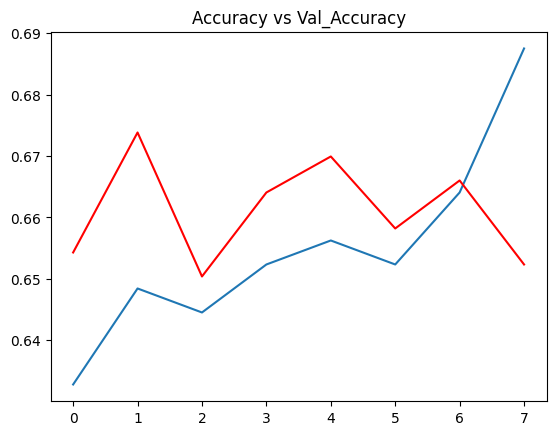

In [25]:
import matplotlib.pyplot as plt

plt.plot(h["accuracy"])
plt.plot(h["val_accuracy"], c= "red")

plt.title("Accuracy vs Val_Accuracy")
plt.show()

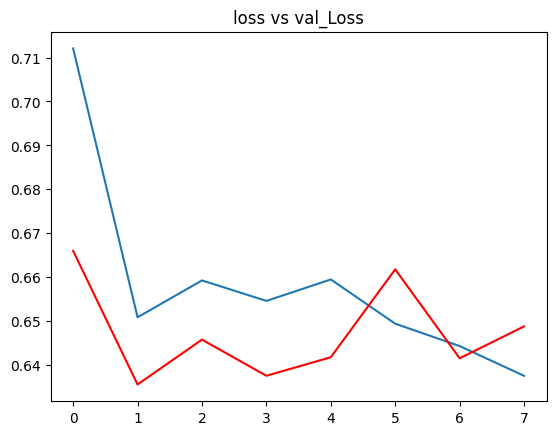

In [28]:
plt.plot(h["loss"])
plt.plot(h["val_loss"], c= "red")

plt.title("loss vs val_Loss")
plt.show()

In [32]:
# Model Accuracy

from tensorflow.keras.models import load_model

model = load_model(r"C:\Users\User\Desktop\I have no idea what im doing\Study\bestmodel.h5")

Model Accuracy

In [34]:
acc = model.evaluate_generator(test_data)[1]

print(f"the accuracy of our model is {acc*100} %")

the accuracy of our model is 61.90476417541504 %


In [36]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

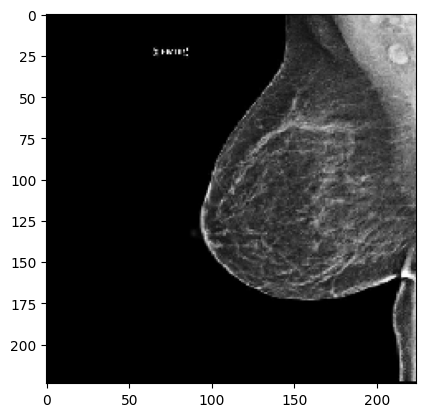

1/1 [==============================] - 0s 109ms/step
0
the MRI is having a Tumor


In [43]:
path = r"C:\Users\User\Desktop\DataSet\Breast Cancer\test\0\49_1074487659_png.rf.ee9d1355df76b8a456cd94ff50d943e9.jpg"

img = load_img(path, target_size= (224, 224))
input_arr = img_to_array(img)/255    # normalize img

plt.imshow(input_arr)
plt.show()

input_arr.shape

# convert into array or numpy function
input_arr = np.expand_dims(input_arr, axis= 0)

pred = model.predict(input_arr)
pred_class = np.argmax(pred, axis=1)[0]  # Get the class with the highest probability
print(pred_class)

if pred_class == 0:
    print("the MRI is having a Tumor")
else:
    print("the MRI is not having a Tumor")

In [41]:
# What is this 0 belongs to?

train_data.class_indices

{'0': 0, '1': 1}